In [18]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [1]:
from google.colab import files
upload = files.upload()

Saving Tweets.csv to Tweets.csv


In [2]:
!ls

sample_data  Tweets.csv


In [79]:
import torch
import torch.nn as nn
import torchtext.data as ttd
import pandas as pd
import numpy as np
from nltk.tokenize import TweetTokenizer, word_tokenize
import matplotlib.pyplot as plt

In [55]:
df = pd.read_csv('Tweets.csv', usecols= ['airline_sentiment', 'text'])
df['label'] = df['airline_sentiment'].map({'positive':2, 'neutral':1, 'negative':0})
df.head()

,airline_sentiment,text,label
0,neutral,@VirginAmerica What @dhepburn said.,1
1,positive,@VirginAmerica plus you've added commercials t...,2
2,neutral,@VirginAmerica I didn't today... Must mean I n...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [56]:
df['label'].value_counts()

0    9178
1    3099
2    2363
Name: label, dtype: int64

In [57]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [58]:
df[['text', 'label']].to_csv('tweets1.csv', index = False)

In [59]:
tk = TweetTokenizer()

In [60]:
TEXT = ttd.Field(batch_first=True, pad_first=True, tokenize = tk.tokenize, lower = True)
LABEL = ttd.Field(sequential=False, use_vocab=False, is_target = True)
dataset = ttd.TabularDataset(path = 'tweets1.csv', format = 'csv', skip_header=True, fields=[('text', TEXT),('label', LABEL)])
train_dataset, test_dataset = dataset.split(.8, stratified = True, strata_field = 'label')

In [61]:
len(dataset)

14640

In [62]:
len(train_dataset) + len(test_dataset)

14640

In [63]:
train_dataset.examples[0].text

['@virginamerica',
 'everything',
 'was',
 'fine',
 'until',
 'you',
 'lost',
 'my',
 'bag']

In [64]:
TEXT.build_vocab(train_dataset, vectors = 'glove.6B.100d')

In [65]:
vocab = TEXT.vocab

In [66]:
vocab.vectors.size()

torch.Size([14757, 100])

In [67]:
vocab.itos[:10]

['<unk>', '<pad>', '.', 'to', 'the', 'i', '!', '?', 'a', ',']

In [68]:
train_iter, test_iter = ttd.Iterator.splits((train_dataset, test_dataset), batch_sizes=(64, 256), sort_key = lambda x: len(x.text))

In [69]:
for inputs, targets in train_iter:
  print(inputs.size(), targets.size())
  break

torch.Size([64, 33]) torch.Size([64])


In [71]:
class RNN(nn.Module):
  def __init__(self, vocab, n_hidden, n_output, n_layers):
    super(RNN, self).__init__()
    self.D = vocab.vectors.size(1)
    self.M = n_hidden
    self.K = n_output
    self.L = n_layers
    self.embed = nn.Embedding.from_pretrained(embeddings=vocab.vectors, padding_idx=vocab.stoi['<pad>'])
    self.rnn = nn.LSTM(input_size=self.D, hidden_size=self.M, batch_first = True, num_layers = self.L)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self,X):
    h0 = torch.zeros(self.L, X.shape[0], self.M)
    c0 = torch.zeros(self.L, X.shape[0], self.M)
    out = self.embed(X)
    out,_ = self.rnn(out, (h0, c0))
    out = self.fc(out[:,-1,:])
    return out


In [72]:
model = RNN(vocab, 128, 3, 1)
model(inputs).shape

torch.Size([64, 3])

In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [74]:
def mini_batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs = 20):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  for i in range(epochs):
    batch_train_loss = []
    for inputs, targets in train_iter:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      batch_train_loss.append(loss.item())

    batch_test_loss = []
    for inputs, targets in test_iter:
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      batch_test_loss.append(loss.item())

    train_losses[i] = np.mean(batch_train_loss)
    test_losses[i] = np.mean(batch_test_loss)
    print(f'epoch:{i+1}/{epochs}; train loss: {train_losses[i]:.4f}, test loss: {test_losses[i]:.4f}')
  return train_losses, test_losses


In [75]:
train_losses, test_losses = mini_batch_gd(model, criterion, optimizer, train_iter, test_iter)

epoch:1/20; train loss: 0.7553, test loss: 0.6165
epoch:2/20; train loss: 0.6054, test loss: 0.5735
epoch:3/20; train loss: 0.5522, test loss: 0.5333
epoch:4/20; train loss: 0.5199, test loss: 0.5141
epoch:5/20; train loss: 0.4896, test loss: 0.4957
epoch:6/20; train loss: 0.4693, test loss: 0.5017
epoch:7/20; train loss: 0.4445, test loss: 0.5062
epoch:8/20; train loss: 0.4239, test loss: 0.4939
epoch:9/20; train loss: 0.3993, test loss: 0.5410
epoch:10/20; train loss: 0.3725, test loss: 0.5015
epoch:11/20; train loss: 0.3498, test loss: 0.5225
epoch:12/20; train loss: 0.3215, test loss: 0.4985
epoch:13/20; train loss: 0.2800, test loss: 0.5546
epoch:14/20; train loss: 0.2534, test loss: 0.5648
epoch:15/20; train loss: 0.2338, test loss: 0.6122
epoch:16/20; train loss: 0.1915, test loss: 0.7156
epoch:17/20; train loss: 0.1602, test loss: 0.7183
epoch:18/20; train loss: 0.1353, test loss: 0.7275
epoch:19/20; train loss: 0.1063, test loss: 0.8773
epoch:20/20; train loss: 0.1040, test lo

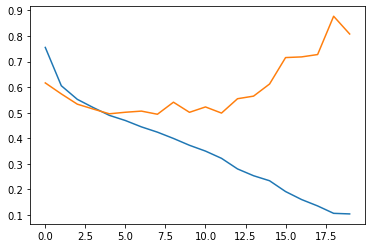

In [80]:
plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.show();

In [76]:
def get_accuracy(model, data_loader):
  ncorrect = 0
  ntotal = 0
  for inputs, targets in data_loader:
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    ncorrect += (predictions==targets).sum().item()
    ntotal += targets.size(0)
  acc = ncorrect/ntotal
  return acc

In [77]:
get_accuracy(model, train_iter)

0.9785671590812057

In [78]:
get_accuracy(model, test_iter)

0.7869580061454421